# Basemap

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import seaborn as sns
from scipy.stats import kde, gaussian_kde

from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PatchCollection
from matplotlib.patches import PathPatch
from matplotlib.patches import Polygon
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.preprocessing import MinMaxScaler,StandardScaler, RobustScaler, LabelEncoder,quantile_transform

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def load_shapefile(shapefilepath):
    m = Basemap()
    m.readshapefile(shapefilepath,"shape")
    print(m.shape_info[0])


Shapefile contains an ID (Name of the region for example) and corresponding polygon.

The data to be plotted has the shared ID as index and a numerical value.

{'OBJECTID': 27, 'Name': 'Roslindale', 'Acres': 1605.5682375, 'Neighborho': '15', 'SqMiles': 2.51, 'ShapeSTAre': 69938272.92557049, 'ShapeSTLen': 53563.912597056624, 'RINGNUM': 1, 'SHAPENUM': 1}


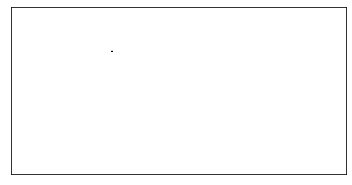

In [3]:
shapefilepath = 'shapefiles/Boston_Neighborhoods'
shapefileId = 'Name'
load_shapefile(shapefilepath)

In [31]:
def plot_colormap(df_map, id_col, value_col, value_type = 'discrete', 
                  shapefilepath = None, shapefileId = 'Name', annotate = [], cmap = 'Reds', fig = None, ax = None):
    """
    df: pandas DataFrame. requirements:
    - Has Longitude & Latitude column
    - Has a [labelcol] column to label the shapes (continuous->colormap, categorical->code)
    - Is indexed by the names of the shapes to plot
    
    labelcol: if continuous, use colormap inferred from data. Otherwise, just distinct colors
    latcol, loncol: name of the columns corresponding to latitude and longitude
    shapefilepath: path of the shape file, without suffix .shp
    shapefileID: attribute in the shapefile that identifies the data
    fig_margin: map zoom level
    annotate: plot labels? Can be messy
    cmap: used in case of continuous variable
    """
    # Color code
    if value_type == 'continuous':
        cmap = plt.get_cmap(cmap)
        value_col_normalized = quantile_transform(df_map[value_col][:, np.newaxis]).flatten()
        colors = dict(zip(df_map[id_col], cmap(value_col_normalized)))
    elif value_type == 'discrete':
        palette = sns.color_palette("hls",df_map[value_col].nunique())
        le = LabelEncoder()
        labels = le.fit_transform(df_map[value_col])
        colors = dict(zip(df_map[id_col], [palette[i] for i in labels]))

    # Plot map
    if fig is None:
        fig, ax = plt.subplots(figsize = (12,12))
    m.readshapefile(shapefilepath,"shape")
    patches = []
    colormap = []
    nodata = []
    """
    id_to_shape = {info[shapefileId]:shape for info,shape in zip(m.shape_info, m.shape)}
    for Id in df_map[id_col].values:
        if not Id in id_to_shape:
            print("No matching shape for ", Id)
        else:
            print(Id)
            polygon = Polygon(np.array(id_to_shape[Id]), True)
            patches.append(polygon)
            colormap.append(colors[Id])
            if Id in annotate:
                x, y = np.median(id_to_shape[Id],axis = 0)
                xpt, ypt = m(x,y)
                plt.annotate(Id,(xpt,ypt),ha='center',
                             **{'color': 'k','fontweight': 'bold','alpha':0.6, 'fontsize': 20})
    for Id in list(set(id_to_shape.keys()).difference(df_map[id_col].values)):
        polygon = Polygon(np.array(id_to_shape[Id]), True)
        patches.append(polygon)
        colormap.append('gray')
    """
    for info, shape in zip(m.shape_info, m.shape):
        polygon = Polygon(np.array(shape), True)
        patches.append(polygon)
        if info[shapefileId] in df_map[id_col].values:
            colormap.append(colors[info[shapefileId]])
            if info[shapefileId] in annotate:
                x, y = np.median(shape,axis = 0)
                #x,y = df_map[df_map[id_col] == info[shapefileId]][[loncol,latcol]].values[0]
                xpt, ypt = m(x,y)
                plt.annotate(info[shapefileId],(xpt,ypt),ha='center',
                             **{'color': 'k','fontweight': 'bold','alpha':0.6, 'fontsize': 20})
        else:
            nodata.append(info[shapefileId])
            colormap.append('lightgray')
    #print("No value for:", set(nodata))
    print("No shapefile for:", list(set(df_map[id_col].values).difference([info[shapefileId] for info in m.shape_info])))
    im = ax.add_collection(PatchCollection(patches, color = colormap, edgecolor='k', 
                                           alpha=0.8, linewidths=1.5, zorder=2))
    handles = [mpatches.Patch(color='gray', label='No data')]
    # plot colorbar if continuous
    if value_type == 'continuous':
        im.set_cmap(cmap)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = fig.colorbar(im,cax=cax, ticks=[0, 0.5, 1])
        #cbar.ax.set_yticklabels(['Low', 'Medium', 'High']) 
    elif value_type == 'discrete': # If categorical, show categories in legend
        handles.extend([mpatches.Patch(color=palette[i], label=le.inverse_transform([i])[0]) for i in np.unique(labels)])
    ax.legend(handles = handles)
    ax.axis('off')
    return

In [28]:
import matplotlib.patheffects as pe

def annotate_map(labels, lon, lat, fig = None, ax = None):
    if fig is None:
        fig, ax = plt.subplots(figsize = (12,12))
    for x,y,z in zip(lon,lat, labels):
        xpt, ypt = m(x, y)
        ax.scatter(xpt, ypt, s = 30, marker = 's')
        ax.annotate(z, (xpt,ypt), fontsize = 20, color = 'white',  
                    path_effects=[pe.withStroke(linewidth=4, foreground="black")])

# Example

### Read shapefile

In [37]:
shapefilepath = 'shapefiles/Boston_Neighborhoods'
shapefileId = 'Name'

### Load and format data

In [38]:
df = pd.read_csv("data/airbnb.csv")
df_map = df.groupby(['city','neighbourhood']).mean().reset_index()
df_map = df_map[df_map['city'] == 'Boston']
df_map.head(5)

,city,neighbourhood,id,log_price,accommodates,bathrooms,cleaning_fee,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,beds
0,Boston,Allston-Brighton,1.091726e+07,4.416305,2.794686,1.258454,0.714976,42.351006,-71.141530,16.623188,92.904192,1.282609,1.594203
1,Boston,Back Bay,1.103168e+07,5.284117,3.250000,1.159247,0.750000,42.349957,-71.080894,22.212838,92.809129,1.071186,1.545763
2,Boston,Beacon Hill,1.044768e+07,5.215321,3.157635,1.137931,0.802956,42.358991,-71.067559,28.605911,94.433333,1.157635,1.536946
3,Boston,Brookline,1.236831e+07,4.807903,3.500000,1.000000,1.000000,42.328920,-71.120915,0.000000,NaN,1.500000,1.500000
4,Boston,Cambridge,1.591164e+07,5.755211,7.000000,1.500000,1.000000,42.366801,-71.094322,0.000000,NaN,3.500000,4.000000


### Set map boundaries

In [39]:
# Set map boundaries, can be changed later
latcol = 'latitude'
loncol = 'longitude'
fig_margin = 0.03
lllat = df_map[latcol].min() - fig_margin # Bottom border
lllon = df_map[loncol].min() - fig_margin # Left border 
urlat = df_map[latcol].max() + fig_margin # Upper border
urlon = df_map[loncol].max() + fig_margin # Right border  

# Create map object and set boundaries
m = Basemap(llcrnrlat = lllat, llcrnrlon=lllon, urcrnrlat=urlat, urcrnrlon=urlon, 
            lat_0=(urlat+lllat)/2, lon_0=(urlon+lllon)/2, resolution = 'c')

###  Map for continuous variable

No shapefile for: ['Allston-Brighton', 'Downtown Crossing', 'Government Center', 'Somerville', 'Chestnut Hill', 'Brookline', 'Coolidge Corner', 'Winthrop', 'Cambridge', 'Financial District', 'Watertown', 'Newton', 'Fenway/Kenmore', 'Theater District', 'Harvard Square']


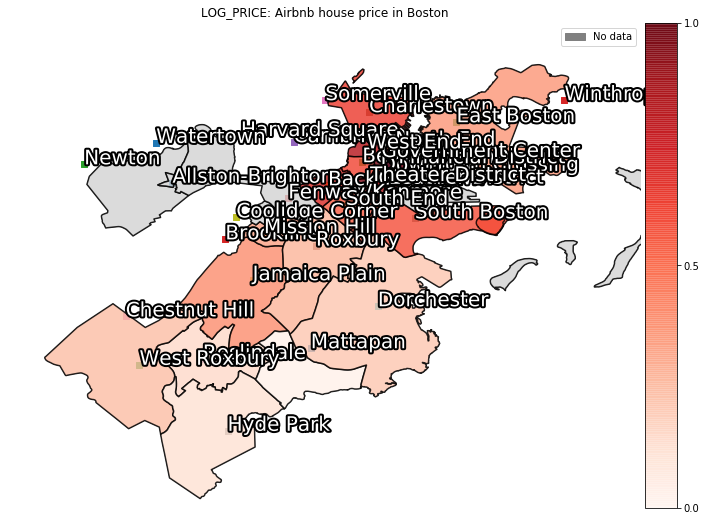

In [40]:
fig, ax = plt.subplots(figsize = (12,12))

plot_colormap(df_map, id_col = 'neighbourhood', value_col = 'log_price',value_type = 'continuous',
        shapefilepath = shapefilepath, shapefileId = shapefileId, cmap = 'Reds', fig = fig, ax = ax)

annotate_map(df_map['neighbourhood'],df_map['longitude'],df_map['latitude'], fig = fig, ax = ax)

ax.set_title("{:s}: Airbnb house price in Boston".format('log_price'.upper()))
fig.show()

###  Map for categorical / discrete variable

In [15]:
df_map['class'] = [1 if i < 12 else 2 for i in range(34)]

No value for: {'Longwood', 'Bay Village', 'Harbor Islands', 'Fenway', 'Allston', 'South Boston Waterfront', 'Brighton'}
No shapefile for: ['Coolidge Corner', 'Fenway/Kenmore', 'Winthrop', 'Newton', 'Brookline', 'Government Center', 'Chestnut Hill', 'Allston-Brighton', 'Downtown Crossing', 'Somerville', 'Watertown', 'Theater District', 'Cambridge', 'Financial District', 'Harvard Square']


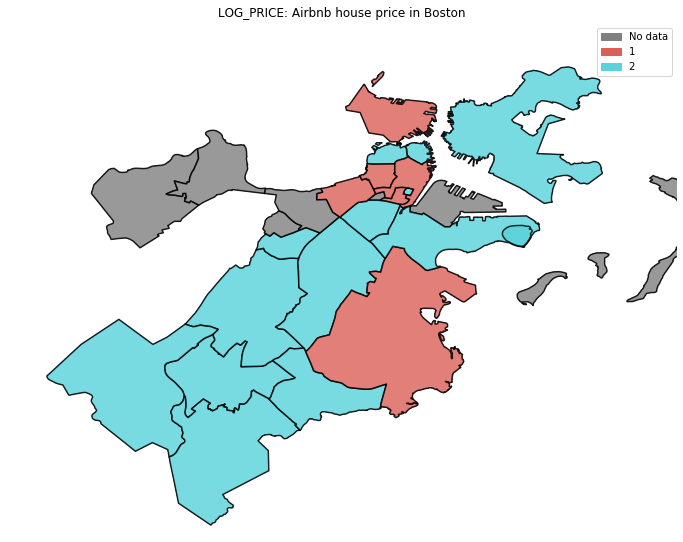

In [16]:
fig, ax = plt.subplots(figsize = (12,12))

plot_colormap(df_map, id_col = 'neighbourhood', value_col = 'class', value_type = 'discrete',
        shapefilepath = shapefilepath, shapefileId = shapefileId, cmap = 'Reds',fig = fig, ax = ax)

ax.set_title("{:s}: Airbnb house price in Boston".format('log_price'.upper()))
fig.show()

# Another city

In [29]:
df = pd.read_csv("data/airbnb.csv")
df_map = df.groupby(['city','neighbourhood']).mean().reset_index()
df_map = df_map[df_map['city'] == 'NYC']

latcol = 'latitude'
loncol = 'longitude'
fig_margin = 0.03
lllat = df_map[latcol].min() - fig_margin # Bottom border
lllon = df_map[loncol].min() - fig_margin # Left border 
urlat = df_map[latcol].max() + fig_margin # Upper border
urlon = df_map[loncol].max() + fig_margin # Right border


m = Basemap(llcrnrlat = lllat, llcrnrlon=lllon, urcrnrlat=urlat, urcrnrlon=urlon, 
            lat_0=(urlat+lllat)/2, lon_0=(urlon+lllon)/2, resolution = 'c')

shapefilepath = 'shapefiles/nyc'
shapefileId = 'boro_name'

df_map.head(5)

,city,neighbourhood,id,log_price,accommodates,bathrooms,cleaning_fee,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,beds
387,NYC,Allerton,1.150657e+07,3.988391,2.25000,1.000000,0.750000,40.867572,-73.866358,19.416667,92.545455,0.833333,1.166667
388,NYC,Alphabet City,1.130425e+07,4.936047,2.68336,1.084951,0.702746,40.724751,-73.980594,20.399031,92.960317,1.144246,1.411669
389,NYC,Annadale,4.699715e+06,4.663439,4.00000,1.000000,0.000000,40.538709,-74.169660,49.000000,99.000000,1.000000,2.000000
390,NYC,Arrochar,1.830997e+07,4.779123,4.00000,1.000000,1.000000,40.597297,-74.071326,0.000000,NaN,1.000000,2.000000
391,NYC,Astoria,1.088715e+07,4.484198,2.80735,1.069119,0.669265,40.763891,-73.922021,20.079065,94.258345,1.183946,1.534002


No shapefile for: ['Soundview', 'Edenwald', 'Willowbrook', 'Chelsea', 'Westerleigh', 'Middle Village', 'Oakwood', 'Belmont', 'Baychester', 'Bronxdale', 'Randall Manor', 'Rossville', 'Soho', 'Forest Hills', 'Concourse Village', 'Chinatown', 'Melrose', 'Times Square/Theatre District', 'Inwood', 'West Village', 'Kew Garden Hills', 'Ridgewood', 'Fort Greene', 'Arrochar', 'Sea Gate', 'Sunnyside', 'Glendale', 'Utopia', 'Graniteville', 'Castle Hill ', 'Bensonhurst', 'Marble Hill', 'Financial District', 'Castleton Corners', 'Gramercy Park', 'Mill Basin', 'Silver Lake', 'The Bronx', 'East New York', 'Greenwood Heights', 'Port Morris', 'Borough Park', 'Dyker Heights', 'Emerson Hill', 'Tompkinsville', 'Washington Heights', 'Bath Beach', 'Lefferts Garden', 'Parkchester', 'Vinegar Hill', 'Norwood', 'Jackson Heights', 'Fort Wadsworth', 'Crown Heights', 'Howard Beach', 'Crotona', 'Little Italy', 'Elmhurst', 'Hunts Point', 'East Elmhurst', 'Morris Park', 'Longwood', 'Sheepshead Bay', 'Lighthouse HIll'

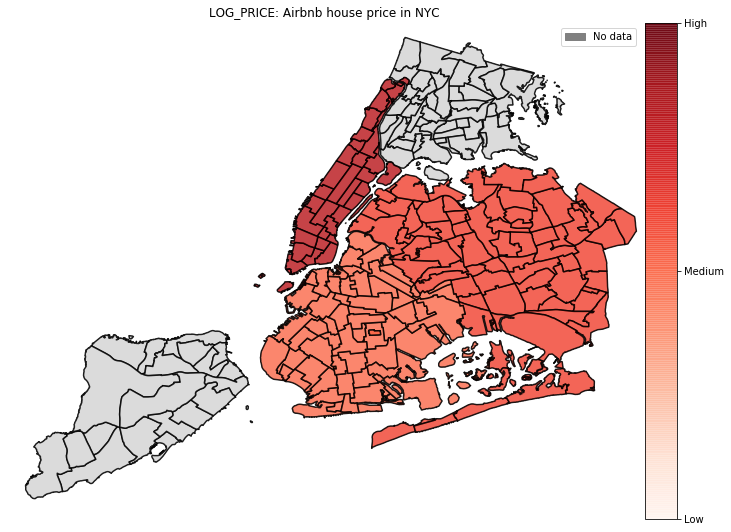

In [30]:
fig, ax = plt.subplots(figsize = (12,12))

plot_colormap(df_map, id_col = 'neighbourhood', value_col = 'log_price',value_type = 'continuous',
        shapefilepath = shapefilepath, shapefileId = shapefileId, cmap = 'Reds',fig = fig, ax = ax)

ax.set_title("{:s}: Airbnb house price in NYC".format('log_price'.upper()))
fig.show()

No shapefile for: ['Soundview', 'Edenwald', 'Willowbrook', 'Chelsea', 'Westerleigh', 'Middle Village', 'Oakwood', 'Belmont', 'Baychester', 'Bronxdale', 'Randall Manor', 'Rossville', 'Soho', 'Forest Hills', 'Concourse Village', 'Chinatown', 'Melrose', 'Times Square/Theatre District', 'Inwood', 'West Village', 'Kew Garden Hills', 'Ridgewood', 'Fort Greene', 'Arrochar', 'Sea Gate', 'Sunnyside', 'Glendale', 'Utopia', 'Graniteville', 'Castle Hill ', 'Bensonhurst', 'Marble Hill', 'Financial District', 'Castleton Corners', 'Gramercy Park', 'Mill Basin', 'Silver Lake', 'The Bronx', 'East New York', 'Greenwood Heights', 'Port Morris', 'Borough Park', 'Dyker Heights', 'Emerson Hill', 'Tompkinsville', 'Washington Heights', 'Bath Beach', 'Lefferts Garden', 'Parkchester', 'Vinegar Hill', 'Norwood', 'Jackson Heights', 'Fort Wadsworth', 'Crown Heights', 'Howard Beach', 'Crotona', 'Little Italy', 'Elmhurst', 'Hunts Point', 'East Elmhurst', 'Morris Park', 'Longwood', 'Sheepshead Bay', 'Lighthouse HIll'

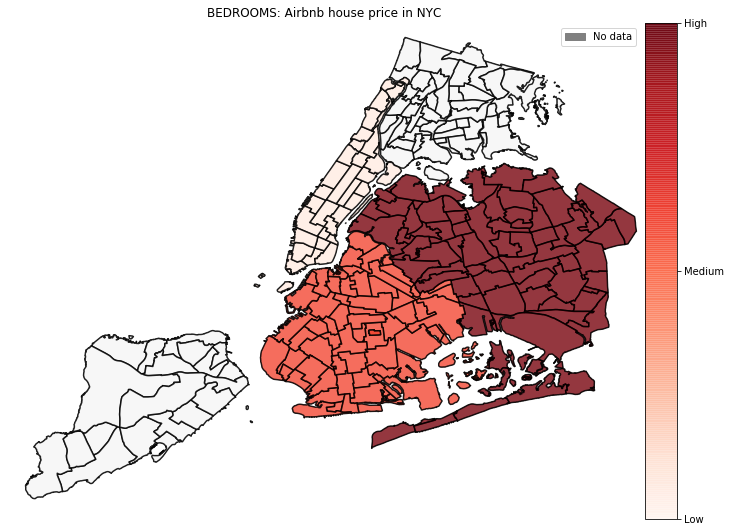

In [26]:
fig, ax = plt.subplots(figsize = (12,12))

plot_colormap(df_map, id_col = 'neighbourhood', value_col = 'bedrooms',value_type = 'continuous',
        shapefilepath = shapefilepath, shapefileId = shapefileId, cmap = 'Reds',fig = fig, ax = ax)

ax.set_title("{:s}: Airbnb house price in NYC".format('bedrooms'.upper()))
fig.show()

# Density map (works only if latitude&longitude per row are provided)

In [25]:
def plot_densitymap(df_map, latcol = 'Lat', loncol = 'Long', shapefilepath = None, shapefileId = 'Name',
            fig_margin = 0.05, annotate = True, cmap = 'Reds', fig = fig, ax = ax):
    """
    Scatter density plot of each row on a map. Need to filter df first
    
    df: pandas DataFrame. requirements:
    - Has Longitude & Latitude column
    - Is indexed by the names of the shapes to plot
    
    latcol, loncol: name of the columns corresponding to latitude and longitude
    shapefilepath: path of the shape file, without suffix .shp
    shapefileID: attribute in the shapefile that identifies the data
    fig_margin: map zoom level
    annotate: plot labels? Can be messy
    cmap: used in case of continuous variable
    threshold: max number of categories. Beyond, will consider as continuous
    """
  
    # Plot contour
    if fig is None:
        fig, ax = plt.subplots(figsize = (12,12))
    m.readshapefile(shapefilepath,"shape")
    patches = []
    for info, shape in zip(m.shape_info, m.shape):
        polygon = Polygon(np.array(shape), True)
        patches.append(polygon)
    ax.add_collection(PatchCollection(patches, color = 'w', edgecolor='k', 
                                           alpha=0, linewidths=1.5, zorder=2))
    ax.axis('off')
    
    # Add density
    x, y = m(df_map[loncol], df_map[latcol])
    if len(df_map) < 50000: # Slower, prettier method
        xy = np.vstack([x,y])
        z = gaussian_kde(xy)(xy)
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]
        im = ax.scatter(x, y, c=z, edgecolor='', cmap = cmap)
    else:
        print("Using histograms")
        _,_,_,im = plt.hist2d(df_map[loncol],df_map[latcol], (300,300), cmap = cmap)
    # Plot colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.05)
    cbar = fig.colorbar(im, cax=cax)
    cbar.ax.axis('off')
    return fig, ax

### Important: set_index otherwise it will be ugly

In [22]:
df = pd.read_csv("data/airbnb.csv")
df_map = df[df['city'] == 'NYC']
df_map = df_map.set_index('neighbourhood')
df_map.head(5)

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,last_review,latitude,longitude,name,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
neighbourhood,,,,,,,,,,,,,,,,,,,,,
Brooklyn Heights,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,...,2016-07-18,40.696524,-73.991617,Beautiful brownstone 1-bedroom,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
Hell's Kitchen,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,...,2017-09-23,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
Harlem,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,...,2017-09-14,40.808110,-73.943756,The Garden Oasis,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
Alphabet City,5578513,4.605170,Apartment,Private room,"{Internet,""Wireless Internet"",""Air conditionin...",2,1.0,Real Bed,strict,True,...,2016-11-15,40.723883,-73.983880,Large East Village Bedroom To Let!,82,93.0,https://a0.muscache.com/im/pictures/21726900/1...,10009.0,1.0,1.0
Lower East Side,17589436,4.882802,Apartment,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",2,1.0,Real Bed,strict,True,...,2016-12-12,40.719086,-73.990285,"Amazing LES apt - cool, bright...",26,86.0,NaN,10002,1.0,2.0


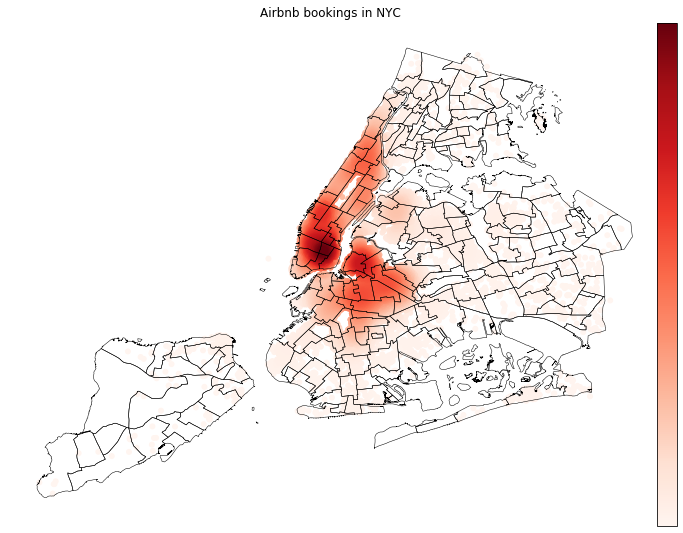

In [26]:
shapefilepath = 'shapefiles/nyc'
shapefileId = 'boro_name'

latcol = 'latitude'
loncol = 'longitude'
fig_margin = 0.03
lllat = df_map[latcol].min() - fig_margin
lllon = df_map[loncol].min() - fig_margin
urlat = df_map[latcol].max() + fig_margin
urlon = df_map[loncol].max() + fig_margin  
# Map boundaries
m = Basemap(llcrnrlat = lllat, llcrnrlon=lllon, urcrnrlat=urlat, urcrnrlon=urlon, 
            lat_0=(urlat+lllat)/2, lon_0=(urlon+lllon)/2)

fig, ax = plt.subplots(figsize = (12,12))

plot_densitymap(df_map, latcol = 'latitude', loncol = 'longitude',
        shapefilepath = shapefilepath, shapefileId = shapefileId,
                fig_margin = fig_margin, annotate = False, cmap = 'Reds', fig = fig, ax = ax)
ax.set_title("Airbnb bookings in NYC")
fig.show()

# San Francisco Zip codes

{'AREA': 271.254383622068, 'PERIMETER': 227.171421517178, 'ST99_D00_': 2, 'ST99_D00_I': 1, 'STATE': '02', 'NAME': 'Alaska', 'LSAD': '01', 'REGION': '4', 'DIVISION': '9', 'LSAD_TRANS': '', 'RINGNUM': 1, 'SHAPENUM': 1}


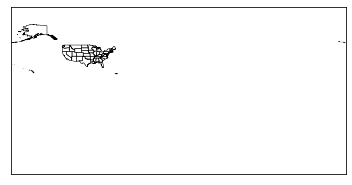

In [64]:
load_shapefile("shapefiles/states")

{'STATEFP': '21', 'COUNTYFP': '007', 'COUNTYNS': '00516850', 'AFFGEOID': '0500000US21007', 'GEOID': '21007', 'NAME': 'Ballard', 'LSAD': '06', 'ALAND': 639387454, 'AWATER': 69473325, 'RINGNUM': 1, 'SHAPENUM': 1}


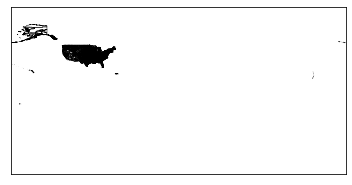

In [66]:
load_shapefile("shapefiles/us_counties")

{'ZCTA5CE10': '36083', 'AFFGEOID10': '8600000US36083', 'GEOID10': '36083', 'ALAND10': 659750662, 'AWATER10': 5522919, 'RINGNUM': 1, 'SHAPENUM': 1}


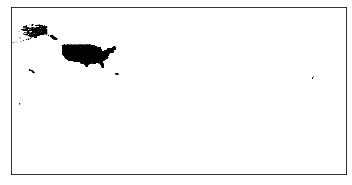

In [16]:
load_shapefile("shapefiles/us_zipcode")

In [4]:
df = pd.read_csv("data/airbnb.csv")
df_map = df.groupby(['city','neighbourhood']).mean().reset_index()
df_map = df_map[df_map['city'] == 'SF']

df_map.head(5)

,city,neighbourhood,id,log_price,accommodates,bathrooms,cleaning_fee,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,beds
588,SF,Alamo Square,1.146679e+07,5.146056,2.948454,1.329897,0.680412,37.776411,-122.433935,23.185567,95.961039,1.360825,1.608247
589,SF,Balboa Terrace,1.107033e+07,4.945967,3.175000,1.350000,0.875000,37.730406,-122.461265,26.000000,95.645161,1.625000,1.950000
590,SF,Bayview,1.148300e+07,4.704966,3.104348,1.191304,0.800000,37.729521,-122.390580,38.121739,92.033333,1.286957,1.713043
591,SF,Bernal Heights,1.107109e+07,5.112653,3.502941,1.311765,0.800000,37.741621,-122.415715,32.894118,95.429091,1.529412,1.873529
592,SF,Chinatown,1.115856e+07,5.140960,2.704545,1.178571,0.454545,37.792697,-122.406742,6.602273,91.478261,0.852273,1.488372


(33144,
 5,
 [-176.684712, -14.37374, 0.0, 0.0],
 [145.830418, 71.341223, 0.0, 0.0],
 <matplotlib.collections.LineCollection at 0x14a8bb198>)

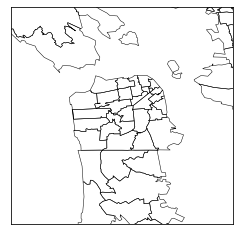

In [13]:
m.readshapefile('shapefiles/us_zipcode',"shape")

(33144,
 5,
 [-176.684712, -14.37374, 0.0, 0.0],
 [145.830418, 71.341223, 0.0, 0.0],
 <matplotlib.collections.LineCollection at 0x14991d3c8>)

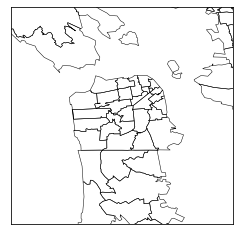

In [5]:
latcol = 'latitude'
loncol = 'longitude'
fig_margin = 0.10
lllat = df_map[latcol].min() - fig_margin # Bottom border
lllon = df_map[loncol].min() - fig_margin # Left border 
urlat = df_map[latcol].max() + fig_margin # Upper border
urlon = df_map[loncol].max() + fig_margin # Right border

m = Basemap(llcrnrlat = lllat, llcrnrlon=lllon, urcrnrlat=urlat, urcrnrlon=urlon, 
            lat_0=(urlat+lllat)/2, lon_0=(urlon+lllon)/2, resolution = 'c')

shapefilepath = 'shapefiles/us_zipcode'
shapefileId = 'ZCTA5CE10'
m.readshapefile(shapefilepath,"shape")

# US Zipcode dataset

https://uszipcode.readthedocs.io/index.html

https://uszipcode.readthedocs.io/01-Tutorial/index.html

In [40]:
import uszipcode
from uszipcode import SearchEngine
search = SearchEngine(simple_zipcode=False)
zipcode = search.by_zipcode("10001")

In [20]:
zipcode.to_dict()

{'zipcode_type': 'Standard',
 'major_city': 'New York',
 'post_office_city': 'New York, NY',
 'common_city_list': ['New York'],
 'county': 'New York County',
 'state': 'NY',
 'lat': 40.75,
 'lng': -73.99,
 'timezone': 'Eastern',
 'radius_in_miles': 0.9090909090909091,
 'area_code_list': ['718', '917', '347', '646'],
 'population': 21102,
 'population_density': 33959.0,
 'land_area_in_sqmi': 0.62,
 'water_area_in_sqmi': 0.0,
 'housing_units': 12476,
 'occupied_housing_units': 11031,
 'median_home_value': 650200,
 'median_household_income': 81671,
 'bounds_west': -74.008621,
 'bounds_east': -73.984076,
 'bounds_north': 40.759731,
 'bounds_south': 40.743451,
 'zipcode': '10001',
 'polygon': [[-73.997113, 40.754616],
  [-73.995816, 40.754057],
  [-73.99562, 40.753973],
  [-73.992979, 40.752854],
  [-73.992528, 40.753474],
  [-73.989694, 40.75228],
  [-73.990134, 40.751659],
  [-73.987779, 40.750661],
  [-73.987294, 40.750451],
  [-73.986794, 40.750241],
  [-73.98442, 40.749246],
  [-73.984

In [22]:
zipcode.to_dict()['travel_time_to_work_in_minutes']

[{'key': 'Data',
  'values': [{'x': '< 10', 'y': 949},
   {'x': '10-19', 'y': 3494},
   {'x': '20-29', 'y': 3274},
   {'x': '30-39', 'y': 2215},
   {'x': '40-44', 'y': 377},
   {'x': '45-59', 'y': 667},
   {'x': '60-89', 'y': 691},
   {'x': '90+', 'y': 234}]}]

In [28]:
search.by_coordinates(39.122229, -77.133578, radius=20)[0].city

'Derwood'

In [36]:
df = pd.read_csv("data/airbnb.csv")
df = df.iloc[:100]
df.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,...,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,...,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,...,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,...,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,...,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


In [42]:
[search.by_coordinates(lon, lat, radius=10)[0].city for lon, lat in zip(df['latitude'],df['longitude'])]

['Brooklyn',
 'New York',
 'New York',
 'San Francisco',
 'Washington',
 'San Francisco',
 'Venice',
 'Los Angeles',
 'San Francisco',
 'Rowland Heights',
 'New York',
 'Manhattan Beach',
 'Redondo Beach',
 'Washington',
 'Long Beach',
 'Chicago',
 'Chicago',
 'Boston',
 'New York',
 'Brooklyn',
 'Van Nuys',
 'Brooklyn',
 'Los Angeles',
 'Van Nuys',
 'Washington',
 'Cambria Heights',
 'Los Angeles',
 'Forest Hills',
 'Los Angeles',
 'New York',
 'Brooklyn',
 'Los Angeles',
 'Venice',
 'West Hollywood',
 'Los Angeles',
 'Brooklyn',
 'San Francisco',
 'Brooklyn',
 'New York',
 'Boston',
 'Chicago',
 'Los Angeles',
 'Los Angeles',
 'Los Angeles',
 'Marina Del Rey',
 'New York',
 'Washington',
 'New York',
 'Brooklyn',
 'Brooklyn',
 'Chicago',
 'New York',
 'San Francisco',
 'Sherman Oaks',
 'Brooklyn',
 'New York',
 'New York',
 'New York',
 'New York',
 'Venice',
 'Boston',
 'Pasadena',
 'San Francisco',
 'Washington',
 'New York',
 'Los Angeles',
 'New York',
 'North Hollywood',
 'Los A